# Single cell proteomics pipeline
#### **Author:** Gerard Font Juvanteny
_MBDS - Master Biomedical Data Science_


---
### Import required libraries


In [1]:
import pandas as pd
from src.data import load_csv

from sklearn.impute import KNNImputer
import numpy as np

from pycombat import pycombat
from scipy.stats import variation

import matplotlib.pyplot as plt


**Setup logs**

---
### Set parameters / constants


In [2]:
# Path to the data
PATH_DATA = './data/processed/2021_Leduc/'
NAME_EXPERIMENT = '2021_Leduc'


---
### Preprocess the data
Based on SCoPE2 method. Code availabe: https://github.com/SlavovLab/SCoPE2/blob/master/code/SCoPE2_analysis.R
<br><br>
**Impute missing values**

In [3]:
# Load the data
df_H = load_csv(PATH_DATA + 'HeLa_noImp.csv')
df_U = load_csv(PATH_DATA + 'U_937_noImp.csv')

# Use the first column as index
df_H = df_H.set_index(df_H.columns[0])
df_U = df_U.set_index(df_U.columns[0])

# Check the shape of the data
print('HeLa shape:', df_H.shape)
print('U_937 shape:', df_U.shape)

# Combine the data
df = pd.concat([df_H, df_U], axis=1)
print('Combined shape:', df.shape)



HeLa shape: (1336, 96)
U_937 shape: (1336, 70)
Combined shape: (1336, 166)


In [6]:
# Check for the presence of missing values within df and print the number of missing values
num_missing_values = df.isnull().sum().sum()

# Percentage of missing values
percentage_missing = num_missing_values / (df.shape[0] * df.shape[1]) * 100

# Get the dimensions of the imputed data
dimensions = df.shape

print(f"Number of missing values: {num_missing_values}")
print(f"Percentage of missing values: {percentage_missing}%")
print(f"Dimensions of the data: {dimensions}")

Number of missing values: 132748
Percentage of missing values: 59.856792439217955%
Dimensions of the data: (1336, 166)


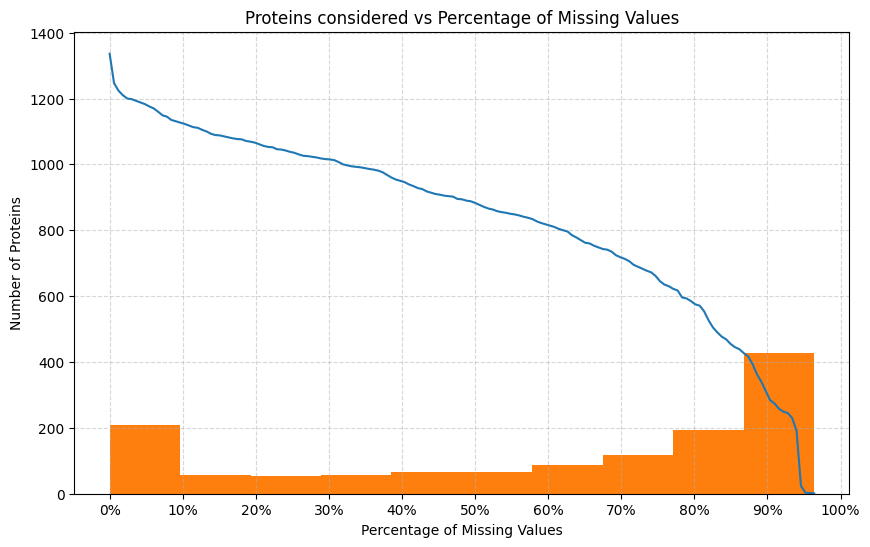

In [7]:

# New column with the percentage of missing values
df['missing'] = df.isnull().mean(axis=1)

plt.figure(figsize=(10, 6))
df['missing'].value_counts().sort_index(ascending=False).cumsum().plot()


# Histogram representing the distribution of the percentage of missing values
df['missing'].plot(kind='hist', bins=10)

plt.xticks(np.arange(0, 1.1, 0.1), [str(i * 10) + '%' for i in range(11)])
plt.xlabel('Percentage of Missing Values')
plt.ylabel('Number of Proteins')
plt.title('Proteins considered vs Percentage of Missing Values')
# add a grid with a dashed style and a transparency of 0.5
plt.grid(linestyle='--', alpha=0.5)

plt.show()



In [8]:
print("Total number of proteins identified: ", df.shape[0])
print(" ")
print("Proteins obtained considering the percentage of missing values equal or higher to:")
for i in range(1, 11):
    print(f'  - {i * 10}% of missing values: {df["missing"].apply(lambda x: x > i / 10).sum()} proteins')




Total number of proteins identified:  1336
 
Proteins obtained considering the percentage of missing values equal or higher to:
  - 10% of missing values: 1123 proteins
  - 20% of missing values: 1061 proteins
  - 30% of missing values: 1015 proteins
  - 40% of missing values: 946 proteins
  - 50% of missing values: 877 proteins
  - 60% of missing values: 814 proteins
  - 70% of missing values: 713 proteins
  - 80% of missing values: 575 proteins
  - 90% of missing values: 284 proteins
  - 100% of missing values: 0 proteins


In [10]:

# Load your data into a DataFrame
imp_input = df  # Assuming ev_matrix_sc_f_n is a pre-loaded DataFrame

# Set the number of neighbors (k.t in R)
k_t = 5  # Replace with your actual value of k.t

# Perform KNN imputation
imputer = KNNImputer(n_neighbors=k_t)
sc_imp = imputer.fit_transform(imp_input)

# Convert the result back to a DataFrame if needed
sc_imp_df = pd.DataFrame(sc_imp, columns=imp_input.columns, index=imp_input.index)

# Check for the presence of any remaining missing values
num_missing_values = np.isnan(sc_imp).sum()

# Percentage of missing values
percentage_missing = num_missing_values / (sc_imp.shape[0] * sc_imp.shape[1]) * 100

# Get the dimensions of the imputed data
dimensions = sc_imp_df.shape

print(f"Number of missing values after imputation: {num_missing_values}")
print(f"Percentage of missing values after imputation: {percentage_missing}%")
print(f"Dimensions of the data after imputation: {dimensions}")

df = sc_imp_df

Number of missing values after imputation: 0
Percentage of missing values after imputation: 0.0%
Dimensions of the data after imputation: (1336, 167)


In [11]:
print(df.head())

                 i10      i105      i106      i107      i108      i109  \
Unnamed: 0                                                               
A0A1B0GX78 -0.227942 -0.695482  0.405415  0.269158 -0.123998 -0.335028   
A0AVF1     -0.305323 -1.027909  0.379671  1.175511 -1.075314  0.968840   
A1A4S6      0.105842 -0.670630  0.567567 -0.384979 -0.126199 -0.247137   
A4FU69     -0.197158 -0.546644 -0.807038 -0.744693  0.168632 -0.413215   
A6H8Y1     -0.201839 -0.252328 -0.103150  0.847710 -0.007273 -0.386630   

                 i11      i110       i12      i122  ...       i78       i79  \
Unnamed: 0                                          ...                       
A0A1B0GX78 -1.017144  0.565018 -0.212762  0.464459  ... -0.618656  0.272579   
A0AVF1     -0.500161 -0.565549  0.421383 -0.299220  ...  0.003035 -0.241462   
A1A4S6      0.321889  0.670054 -0.607231  1.103305  ...  1.204707  0.022834   
A4FU69     -0.234762  0.478290  0.386816  0.539271  ... -0.212650  0.437855   
A6H8Y1 

**Batch Correction**

IMPORTANT: Missing metadata about Batches!! not even in the raw files (7,30GB + 37,98GB)